## This notebook is to prepare three components: CLM, HF, and time-varying delta percentage change, for making river forcing for future projection
* Please see **"create_45_rivers_forcing_02.ipynb"** for the final steps to create the forcing.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lo_tools import Lfun
Ldir = Lfun.Lstart()

In [2]:
# define path to read files from
in_dir = Ldir['LOo'] / 'forcing' / 'cas2k' / 'river'
out_dir = in_dir/'climatology'
Lfun.make_dir(out_dir)
# define path to save figures
fig_dir = Ldir['LOo'] / 'plots' / 'river_forcing'

### 1. Compute the climatology river flow based on day of year
* where the historical river forcing was extracted using **"extract_45_river_forcing.py"**

In [3]:
ds = xr.open_dataset(f'{in_dir}/river_historical_1993-2022.nc') 
# add new variable dayofyear 
ds = ds.assign_coords(dayofyear=ds['river_time'].dt.dayofyear)
# group mean 
dt = ds.groupby('dayofyear').mean(dim='river_time')
# Save to NetCDF
dt.to_netcdf(f'{out_dir}/river_flow_CLM.nc')

### 2. Compute the High Frequency (HF) river
*  each day from the forcing subtracted by the 30 days moving average of the forcing, save to .nc
*  each day from the forcing subtracted by the dayofyear climatology, save to .nc

In [4]:
vn = 'river_transport'
# Compute high-frequency variability (daily value - dayofyear climatology)
ds['river_hf'] = ds[vn].groupby('dayofyear') - dt[vn]  
# Save to NetCDF
ds['river_hf'].to_netcdf(f'{out_dir}/river_flow_high_freq.nc')

# Compute high-frequency variability (daily value - 30-day moving average)
"""
note: Computes the rolling mean over 30 days, looking backward by default.
Moves the result backward by 29 days, making it forward-looking (including the current day and the next 29 days)
"""
ds[f'{vn}_30d_avg'] = ds[vn].rolling(river_time=30, center=False).mean().shift(river_time=-29) # the last month returns NaN, 
ds['river_hf'] = ds[vn] - ds[f'{vn}_30d_avg']

# Save to NetCDF
ds['river_hf'].to_netcdf(f'{out_dir}/river_flow_high_freq_01.nc')

### 3. Compute time-varying delta from CMIP6 SSP2-4.5 GFDL ESM4.0


In [5]:
# the path for the ESM4.0 data
ri_dir = Ldir['LOo'] / 'pre' / 'river'/'GFDL_ESM4'
esm_river = xr.open_dataset(f"{ri_dir}/GFDL-ESM4_ssp245_LO_domain_friver_monthly.nc")
esm_river = esm_river.where(esm_river.y < 50.3, drop=True) # select the domain fit to 45 rivers 
hist_river = esm_river.sel(time=slice('1993-01-01', '2022-12-31')) # historical period
fut_river = esm_river.sel(time=slice('2023-01-01', None)) # future period

# Add the 'month' as a new variable in the dataset
hist_river['month'] = hist_river['time'].dt.month
fut_river['month'] = fut_river['time'].dt.month
# Set 'month' as a coordinate to avoid the warning
hist_river = hist_river.set_coords('month')
fut_river = fut_river.set_coords('month')

#### 3.1. Compute monthly climatology (1993-2022) for 12 months  

In [6]:
# Group by 'month' and calculate the mean for each month
CLM = hist_river.groupby('month').mean(dim='time')

#### 3.2. Compute delta (time-varying): 2023 Jan – CLM Jan, 2023 Feb – CLM FEB, …, for the whole future period (2023-2100)

In [7]:
delta = fut_river.copy()  # Create a copy to store the result
# Compute the delta: future monthly values minus the climatological mean
for var in fut_river.data_vars:
    delta[var] = fut_river[var].groupby('time.month') - CLM[var]
# Rename 'friver' to 'delta_friver' if it exists in the dataset
if 'friver' in delta:
    delta = delta.rename({'friver': 'delta_friver'})

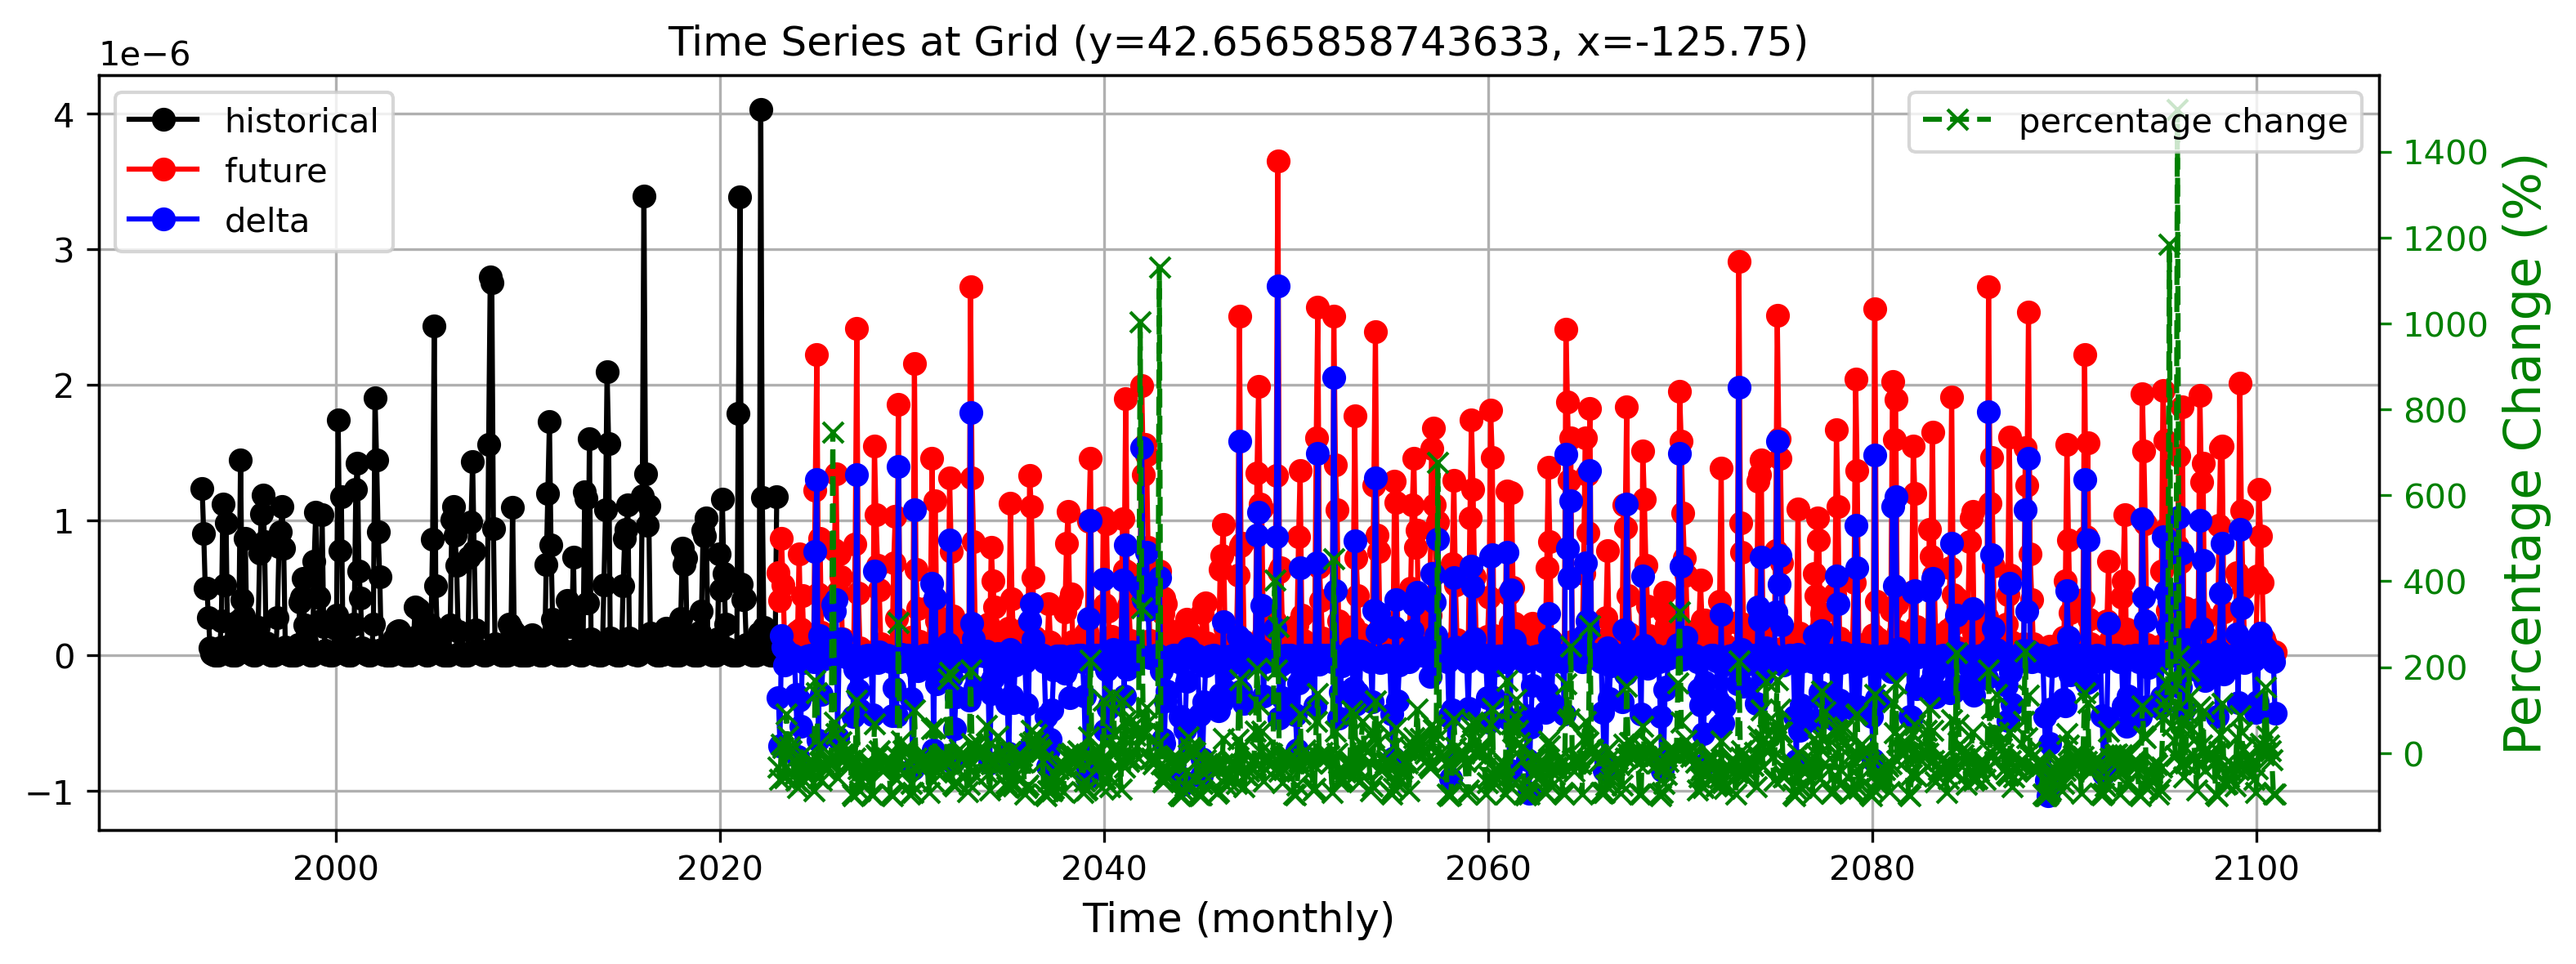

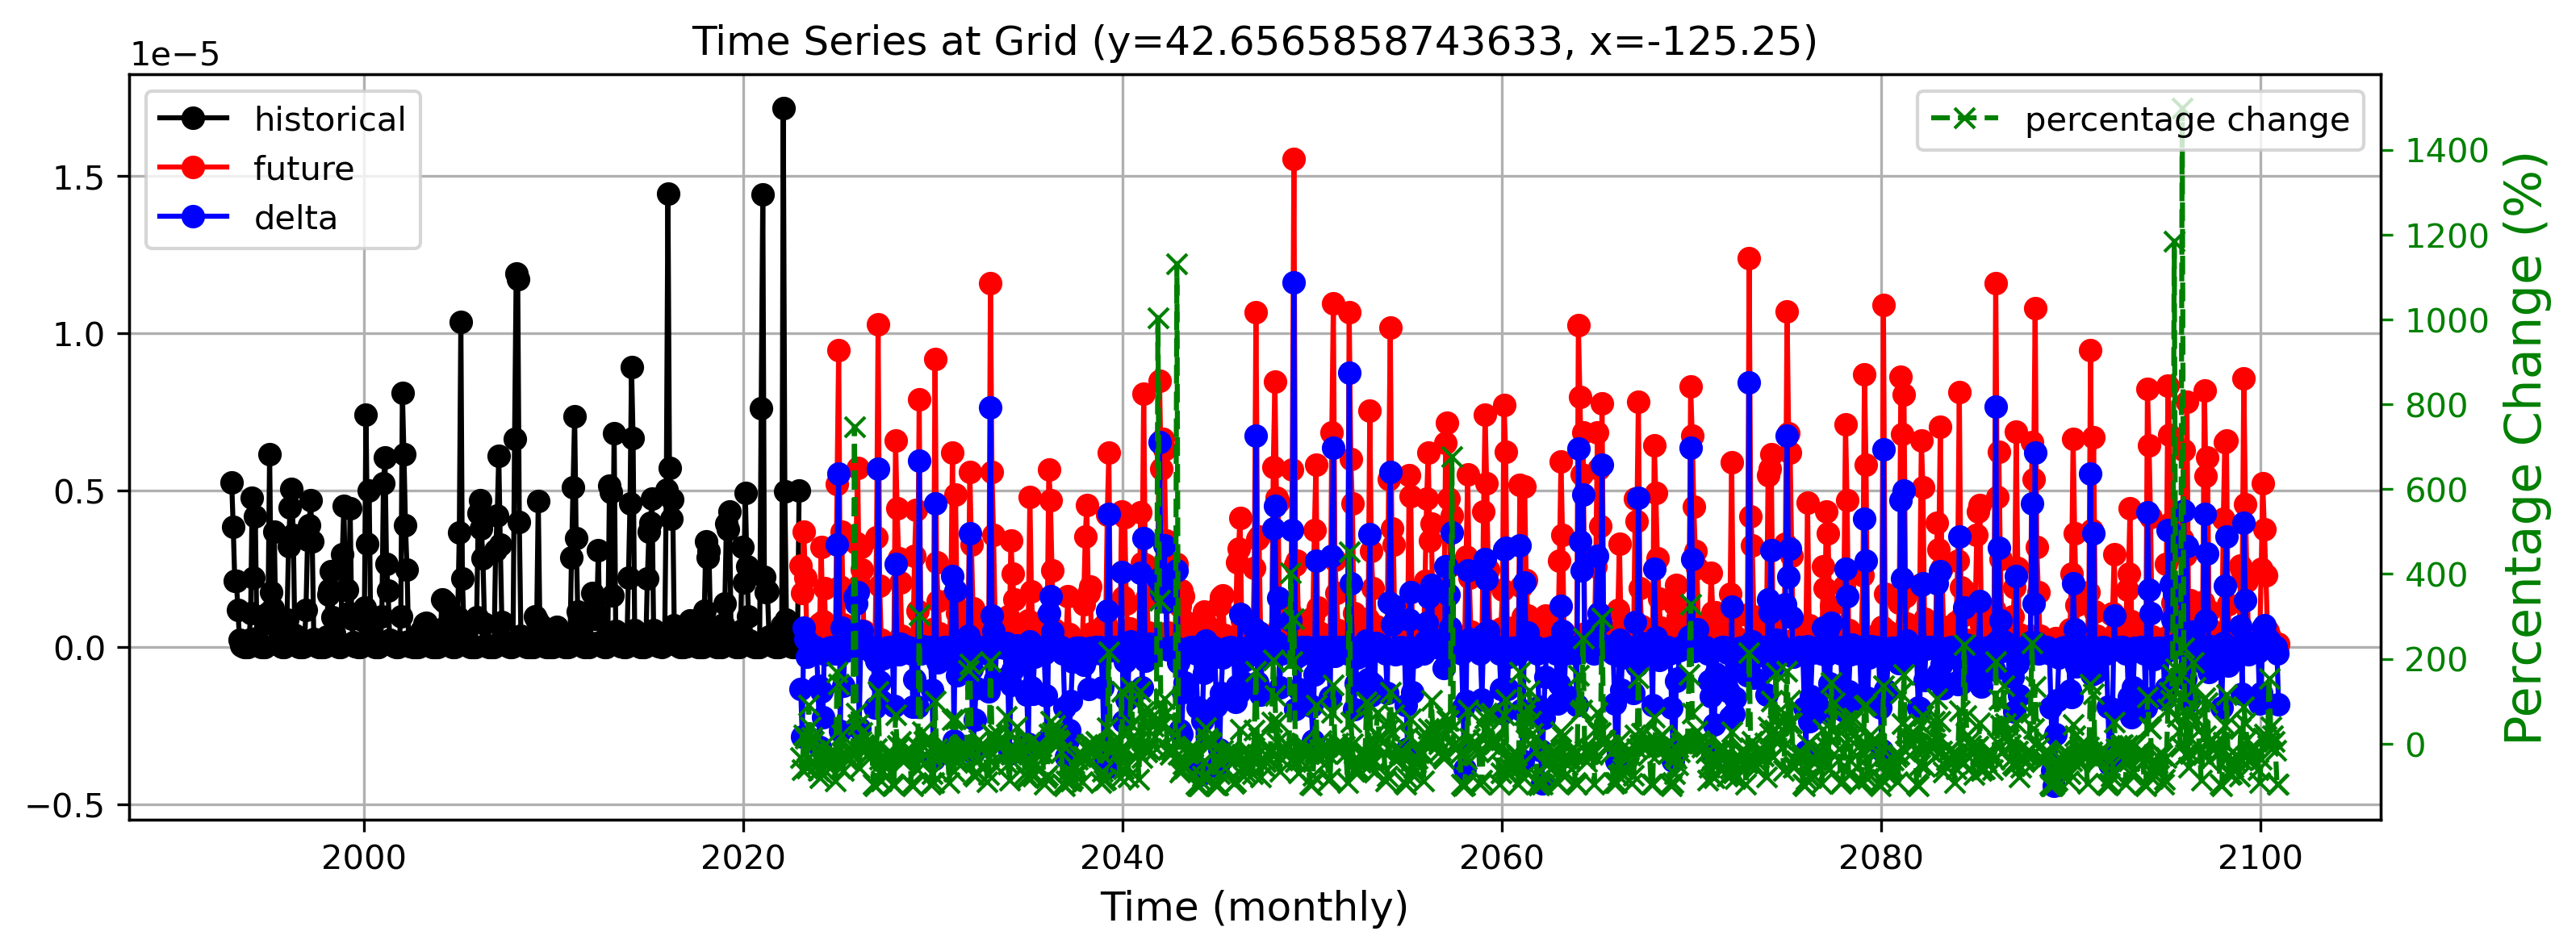

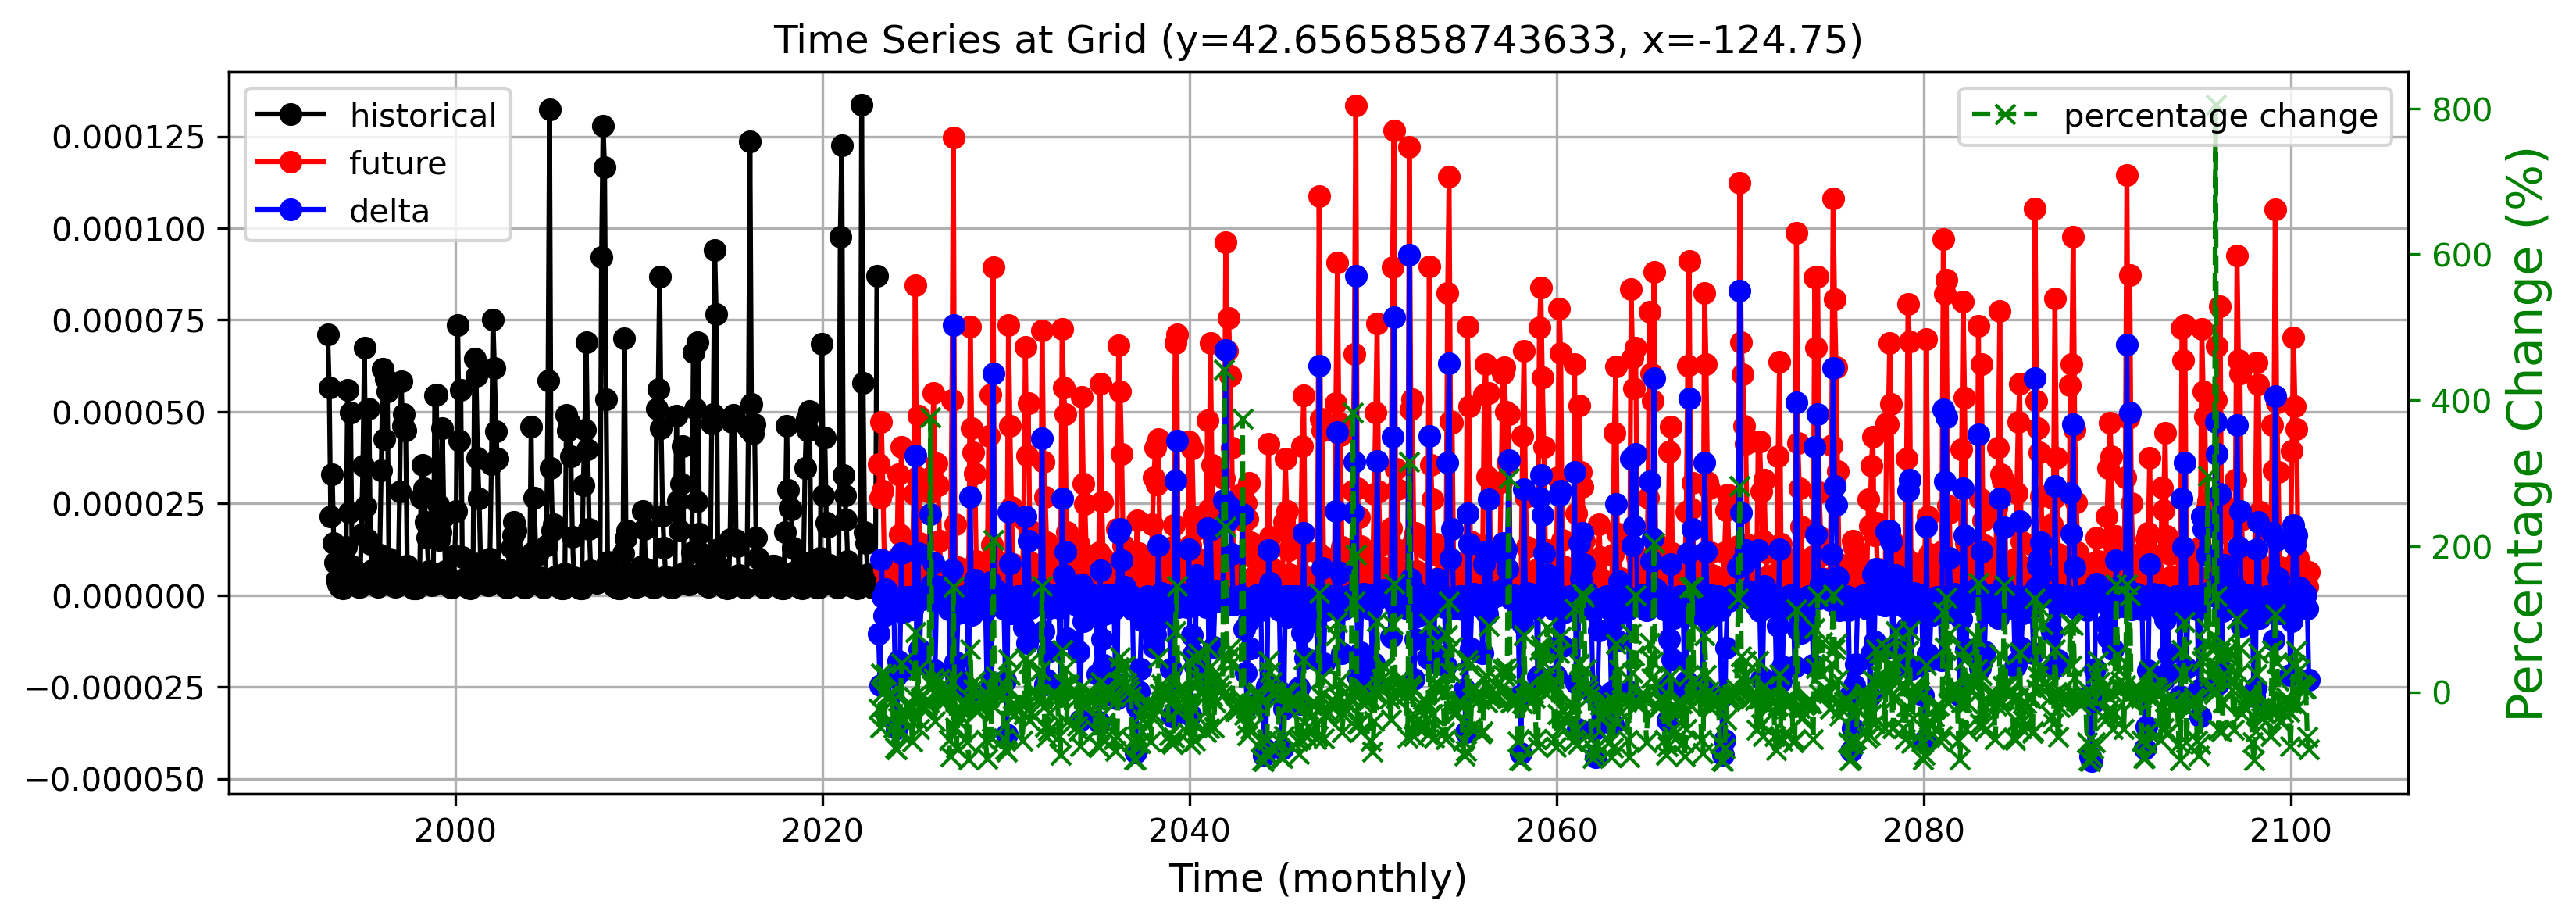

Total grid numbers are: 81


In [8]:
# Loop through each grid point
time = delta['time'].values 
his_time = hist_river['time'].values
fut_time = fut_river['time'].values

# Ensure nanosecond precision for datetime values to avoid error
fut_time_ns = np.array(fut_time, dtype='datetime64[ns]')
# Now you can extract the month and index with nanosecond precision
months = pd.to_datetime(fut_time_ns).month

ii =0
# Initialize empty lists to store all valid grids
y_list = [] 
x_list = [] 
for i in range(delta.sizes['y']):
    for j in range(delta.sizes['x']):
        values = esm_river['friver'].isel(y=i, x=j).values        
        if not np.all(np.isnan(values)) and not np.all(values == 0.0): # filter out empty grids
            DELTA = delta['delta_friver'].isel(y=i, x=j).values  # Extract time series at (y, x)   
            FUT = fut_river['friver'].isel(y=i, x=j).values
            HIS= hist_river['friver'].isel(y=i, x=j).values            
            # get the percentage change relative to CLM,
            HIS_CLM = CLM['friver'].isel(y=i, x=j, month=months - 1).values # broadcasting behavior
            percent_change = (DELTA / HIS_CLM) * 100
            
            if not np.all(np.isnan(DELTA)) and not np.all(DELTA == 0.0):
                ii += 1
                y_list.append(i)
                x_list.append(j)
                # Create a plot
                fig, ax1 = plt.subplots(figsize=(12, 4), dpi=300)
    
                # Plot historical, future, and delta time series on the left y-axis
                ax1.plot(his_time, HIS, marker='o', linestyle='-', color='black', label='historical')
                ax1.plot(time, FUT, marker='o', linestyle='-', color='red', label='future')
                ax1.plot(time, DELTA, marker='o', linestyle='-', color='blue', label='delta')
    
                # Add labels and title for left y-axis
                ax1.set_xlabel('Time (monthly)',fontsize=12)
                # ax1.set_ylabel('Friver Value')
                ax1.set_title(f'Time Series at Grid (y={delta.y[i].values}, x={delta.x[j].values})')
                ax1.grid()
    
                # Add a secondary y-axis to plot percentage change
                ax2 = ax1.twinx()
                ax2.plot(time, percent_change, marker='x', linestyle='--', color='green', label='percentage change',markersize=6)
                ax2.set_ylabel('Percentage Change (%)', color='green',fontsize=15)
                # Change the color of the y-axis ticks to green
                ax2.tick_params(axis='y', labelcolor='green',colors='green')
                # Add legends for both axes
                ax1.legend(loc='upper left')
                ax2.legend(loc='upper right')
                # Save the plot as a PNG file
                plot_filename = f"{fig_dir}/ESM4.0_river_SSP2-4.5_y{i}_x{j}.png"
                plt.savefig(plot_filename)    
                if i == 1:
                    plt.show() # Show the plot  
                else:
                    plt.close()

print('Total grid numbers are:', ii)


#### 3.3. Calculate the percentage change relative to monthly climatology

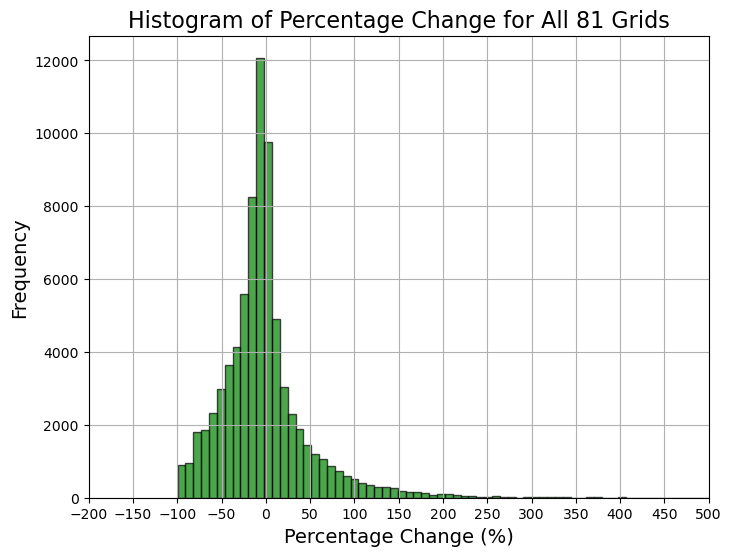

In [9]:
# Initialize an empty list to store all percentage changes
percent_changes = []

# Loop through each grid point (using y_list and x_list)
for i, j in zip(y_list, x_list):
    DELTA = delta['delta_friver'].isel(y=i, x=j).values  # Extract delta values for (y, x)
    FUT = fut_river['friver'].isel(y=i, x=j).values
    HIS = hist_river['friver'].isel(y=i, x=j).values

    # Get the percentage change relative to CLM
    HIS_CLM = CLM['friver'].isel(y=i, x=j, month=months - 1).values
    mask = ~np.isnan(HIS_CLM) & (HIS_CLM != 0)
    percent_change = np.where(mask, (DELTA / HIS_CLM) * 100, np.nan)  # Calculate the percentage change

    # Store the percentage changes in the list (only if not NaN)
    percent_changes.extend(percent_change[~np.isnan(percent_change)])  # Add valid percentage change values
    
# Now plot the histogram of the percentage changes
plt.figure(figsize=(8, 6))
plt.hist(percent_changes, bins=180, color='green', edgecolor='black', alpha=0.7)
plt.title(f'Histogram of Percentage Change for All {ii} Grids', fontsize=16)
plt.xlabel('Percentage Change (%)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xlim(-200, 500)
plt.xticks(np.arange(-200, 501, 50))
plt.grid(True)
filename = f"{fig_dir}/ESM4.0_river_percent_change_for_ALL_{ii}_grids_histogram.png"
plt.savefig(filename)
plt.show()


#### 3.4. Calculate the mean percentage change for the whole region (averaging) 

the mean % change of all grids and period is: -1.37
Shape of percent_changes array: (75816,)
Shape of reshaped_percent_changes array: (81, 936)
Shape of mean_percent_change: (936,)
mean_percent_change has NaNs?: False


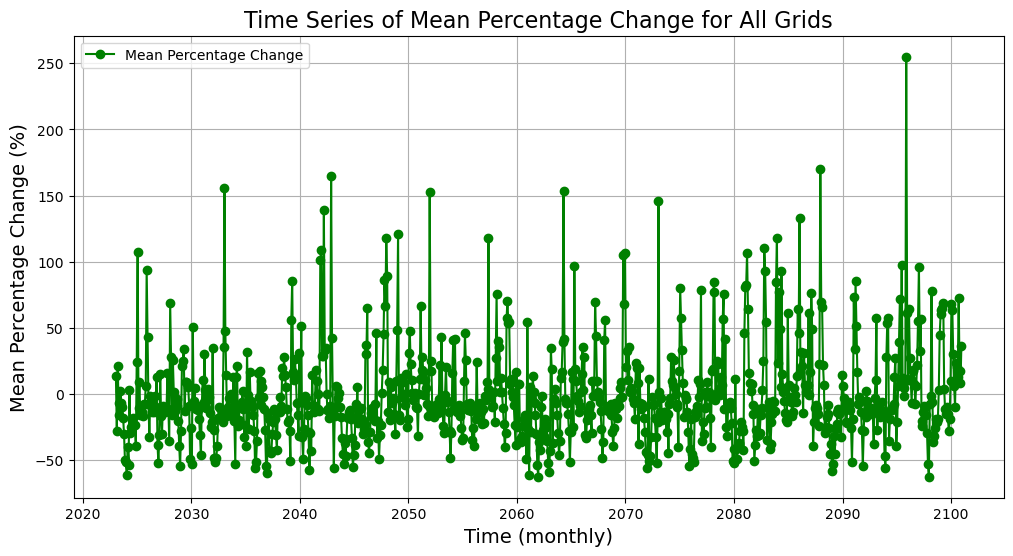

In [10]:
mean_percent_change_all = np.nanmean(percent_changes, axis=0)
print(f"the mean % change of all grids and period is: {mean_percent_change_all:.2f}")

percent_changes_array = np.array(percent_changes)
print(f"Shape of percent_changes array: {percent_changes_array.shape}")  # Check the shape of the percent_changes array

reshaped_percent_changes = percent_changes_array.reshape(-1, len(time))  # reshape the array
print(f"Shape of reshaped_percent_changes array: {reshaped_percent_changes.shape}")

mean_percent_change = np.nanmean(reshaped_percent_changes, axis=0) # Calculate mean across all grids (time-series)
print(f"Shape of mean_percent_change: {mean_percent_change.shape}")
print(f'mean_percent_change has NaNs?: {np.isnan(mean_percent_change).any()}')

# Now plot the time series of the mean percentage change
plt.figure(figsize=(12, 6))
plt.plot(time, mean_percent_change, color='green', marker='o', linestyle='-', label='Mean Percentage Change')
plt.title('Time Series of Mean Percentage Change for All Grids', fontsize=16)
plt.xlabel('Time (monthly)', fontsize=14)
plt.ylabel('Mean Percentage Change (%)', fontsize=14)
plt.grid(True)
plt.legend()
fname = f"{fig_dir}/ESM4.0_river_mean_percent_change.png"
plt.savefig(fname)
plt.show()

#### 3.5. Apply method (cubic interpolation) to downscale the percentage change from monthly to daily 


In [11]:
# Create monthly time steps covering the future period (2023-2100)
monthly_time = np.arange(np.datetime64('2023-01-01'), np.datetime64('2100-12-31')+ np.timedelta64(1, 'D'), dtype='datetime64[M]')  
monthly_time = monthly_time.astype('datetime64[ns]')  # Convert to nanosecond precision to avoid error
# Generate daily time steps covering the future period (2023-2100)
daily_time = np.arange(np.datetime64('2023-01-01'), np.datetime64('2100-12-31') + np.timedelta64(1, 'D'), dtype='datetime64[D]')
daily_time = daily_time.astype('datetime64[ns]')  # Convert to nanosecond precision to avoid error

# Create a DataArray with the time dimension and percent change as values
mean_percent_change_da = xr.DataArray(mean_percent_change, coords=[monthly_time], dims=["time"])
# rename the variable name 
mean_percent_change_da = mean_percent_change_da.rename("percent_change")
# save monthly file
mean_percent_change_da.to_netcdf(f'{out_dir}/river_flow_percent_change_monthly.nc')

In [12]:
# Interpolate to daily resolution using cubic interpolation
daily_delta_percent_change = mean_percent_change_da.interp(time=daily_time, method="cubic", kwargs={"fill_value": "extrapolate"})
# Check the shape and result of the interpolation
print(f"Interpolated daily percent change shape: {daily_delta_percent_change.shape}")
# rename the variable name 
daily_delta_percent_change = daily_delta_percent_change.rename("percent_change")
# save daily file
daily_delta_percent_change.to_netcdf(f'{out_dir}/river_flow_percent_change_daily.nc')

Interpolated daily percent change shape: (28489,)


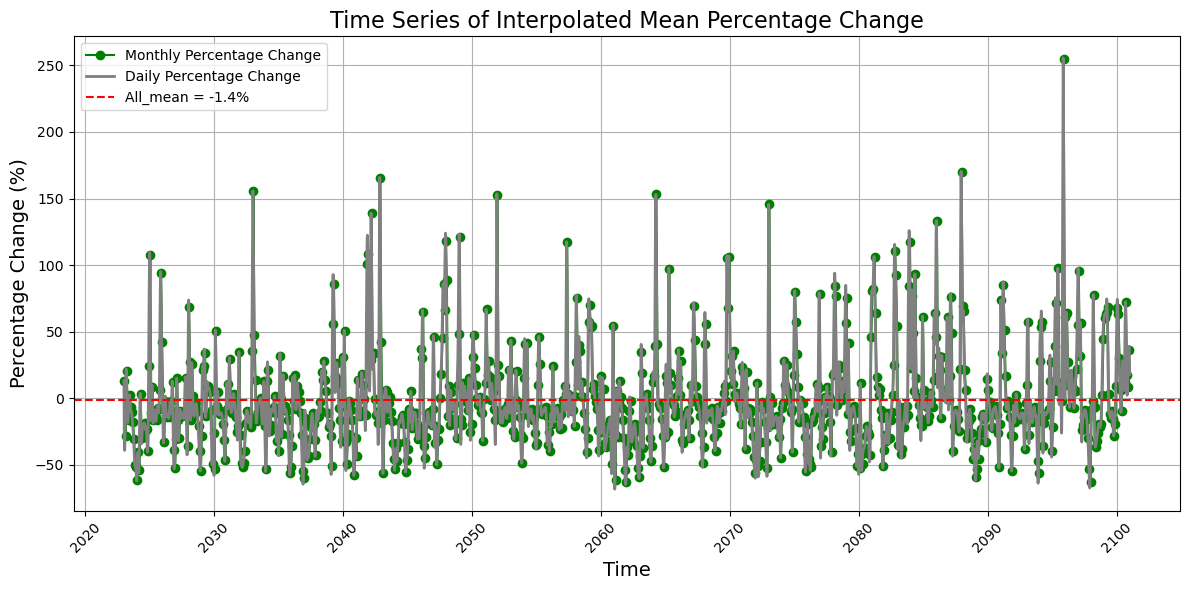

In [13]:
# Convert the daily_percent_change to a NumPy array for easier plotting
daily_percent_change_values = daily_delta_percent_change.values

# Plot the percentage change over time
plt.figure(figsize=(12, 6))
plt.plot(time, mean_percent_change, color='green', marker='o', linestyle= None, label='Monthly Percentage Change')
plt.plot(daily_time, daily_percent_change_values, label='Daily Percentage Change', color='gray', linewidth=2)
plt.axhline(y=mean_percent_change_all, color='red', linestyle='--', label=f'All_mean = {mean_percent_change_all:.1f}%')
# Add labels and title
plt.xlabel('Time', fontsize=14)
plt.ylabel('Percentage Change (%)', fontsize=14)
plt.title('Time Series of Interpolated Mean Percentage Change', fontsize=16)
plt.grid(True)
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.tight_layout()
ffn = f"{fig_dir}/ESM4.0_river_SSP2-4.5_mean_percent_change_daily.png"
plt.savefig(ffn)
# Show the plot
plt.show()